In [3]:
# Load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
# Read the data files
df = pd.read_csv('cleaned_data.csv')

**The purpose of this worksheet is to understand the actual definition of different lapse categories**

In [45]:
df.head()

,CHANNEL1,CHANNEL2,CHANNEL3,ENTRY AGE,SEX,POLICY TYPE 1,POLICY TYPE 2,POLICY TYPE 3,PAYMENT MODE,POLICY STATUS,BENEFIT,NON LAPSE GUARANTEED,SUBSTANDARD RISK,NUMBER OF ADVANCE PREMIUM,INITIAL BENEFIT,Full Benefit?,Policy Year (Decimal),Policy Year,Premium,Issue Date
0,1,1,1,36,F,1,1,A,Annually,Inforce,200000.0,NO NLG,0.0,0,0.0,N,8.000000,9,280.0,11-Aug
1,1,1,1,42,M,1,2,A,Annually,Inforce,100000.0,NO NLG,0.0,0,0.0,N,8.000000,9,200.0,11-Aug
2,1,1,2,40,M,2,3,A,Annually,Lapse,80000.0,NO NLG,0.0,0,0.0,N,8.000000,9,1289.0,11-Aug
3,1,1,3,39,M,1,2,A,Monthly,Lapse,100000.0,NO NLG,0.0,0,0.0,N,8.000000,9,216.0,11-Aug
4,1,1,4,44,M,1,2,A,Annually,Lapse,100000.0,NO NLG,0.0,0,0.0,N,7.916667,8,140.0,11-Sep


In [46]:
# Reformat the Issue Date into YYYY-MM-01 format
# Since there is no actual issue date, we assume the day to be 1
df['Issue Date'] = pd.to_datetime(df['Issue Date'], format='%y-%b')

# Adding a new column to compute the actual ending date of the policy
from dateutil.relativedelta import relativedelta

# Function to calculate the current policy date
def calculate_dates(row):
    issue_date = row['Issue Date']
    decimal_year = row['Policy Year (Decimal)']
    
    # Calculate whole years and remaining decimal for months
    years = int(decimal_year)
    remaining_months_decimal = (decimal_year - years) * 12
    months = round(remaining_months_decimal)
    
    # Compute the "Effective Date" represented by this row
    current_eval_date = issue_date + relativedelta(years=years, months=months)

    return current_eval_date

df['Current Policy Date'] = df.apply(calculate_dates, axis=1)
df.head()

,CHANNEL1,CHANNEL2,CHANNEL3,ENTRY AGE,SEX,POLICY TYPE 1,POLICY TYPE 2,POLICY TYPE 3,PAYMENT MODE,POLICY STATUS,...,NON LAPSE GUARANTEED,SUBSTANDARD RISK,NUMBER OF ADVANCE PREMIUM,INITIAL BENEFIT,Full Benefit?,Policy Year (Decimal),Policy Year,Premium,Issue Date,Current Policy Date
0,1,1,1,36,F,1,1,A,Annually,Inforce,...,NO NLG,0.0,0,0.0,N,8.000000,9,280.0,2011-08-01,2019-08-01
1,1,1,1,42,M,1,2,A,Annually,Inforce,...,NO NLG,0.0,0,0.0,N,8.000000,9,200.0,2011-08-01,2019-08-01
2,1,1,2,40,M,2,3,A,Annually,Lapse,...,NO NLG,0.0,0,0.0,N,8.000000,9,1289.0,2011-08-01,2019-08-01
3,1,1,3,39,M,1,2,A,Monthly,Lapse,...,NO NLG,0.0,0,0.0,N,8.000000,9,216.0,2011-08-01,2019-08-01
4,1,1,4,44,M,1,2,A,Annually,Lapse,...,NO NLG,0.0,0,0.0,N,7.916667,8,140.0,2011-09-01,2019-08-01


# Checking if we can combine Lapse and Surrender into one group

In [47]:
df['POLICY STATUS'].unique()
# Was thinking of combining categories, but before that, let's see the distribution of target variables between them

array(['Inforce', 'Lapse', 'Expired', 'Surrender', 'Death'], dtype=object)

**Definition of Policy Status**

1. Inforce (Active)
- The policy is active and performing.
- Definition: The contract is in full effect, premiums are being paid (or the policy is paid-up), and the insurer is currently providing coverage.
- Modeling Role: In a Cox model, these are Censored observations because the "event" (lapse) has not happened yet as of the data snapshot.


2. Lapse (Passive Termination)
- The policy has terminated due to non-payment of premiums.
- Definition: The policyholder stopped paying, and the "grace period" (usually 30–61 days) has expired. The policy is canceled by the company, and typically, no death benefit or cash value is paid out.
- Behavioral Driver: Often linked to financial distress, forgetfulness, or "buyer's remorse" early in the policy life.


3. Surrender (Active Termination)
- The policyholder voluntarily terminates the contract to collect the Cash Value.
- Definition: This applies primarily to "Permanent" or "Whole Life" policies that build equity. The policyholder explicitly asks to cancel the policy in exchange for the "Surrender Value" (the accumulated savings minus fees).
- Behavioral Driver: Often a strategic financial decision—the policyholder needs cash for an emergency, is switching to a different investment, or no longer needs the coverage.


4. Expired (Natural Maturity)
- The policy reached its contractual end date.
- Definition: Most common in "Term Life" insurance. If you buy a 20-year term policy and stay alive for 20 years, the policy "expires." No benefit is paid, and the contract simply ends.
- Modeling Role: These are Censored. They didn't "quit"; they finished the marathon.


5. Death (Claim Paid)
- The insured event occurred, and the company paid the death benefit.
- Definition: The policy fulfilled its primary purpose. The contract is terminated because the claim was settled.
- Modeling Role: In survival analysis, this is a Competing Risk. A person cannot "Lapse" a policy if they are already deceased.

*Thoughts: My goal is to predict voluntary exit initiated by the policyholders -- so I was thinking of combining Lapse and Surrender together
But before that we need to do some EDA to make sure they have the similar distribution*

In [48]:
pip install lifelines

Note: you may need to restart the kernel to use updated packages.


Text(0, 0.5, 'Probability of NOT Terminating')

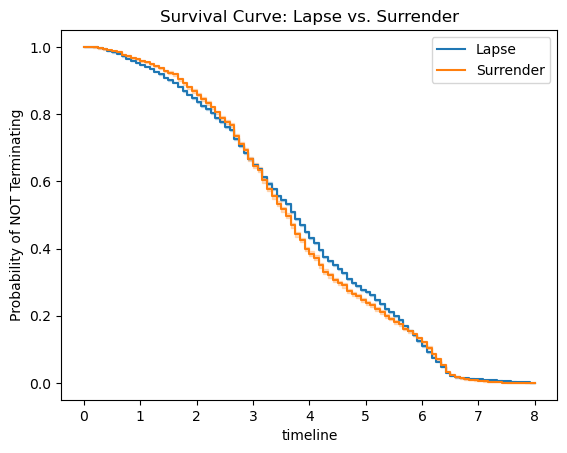

In [49]:
# Check if the timing profiles of Lapse and Surrender is the same
# Test 1: Check the distribution for the Cox model

from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()
for status in ['Lapse', 'Surrender']:
    mask = df['POLICY STATUS'] == status
    # Note: Use 'Policy Year (Decimal)' for higher precision timing
    kmf.fit(df[mask]['Policy Year (Decimal)'], label=status)
    kmf.plot_survival_function()

plt.title('Survival Curve: Lapse vs. Surrender')
plt.ylabel('Probability of NOT Terminating')

# Both curves overlap almost perfectly, 
# suggesting that the timing profiles of Lapse and Surrender are very similar. 
# This supports the idea of combining them into a single "Terminated" category for modeling purposes.

<Axes: xlabel='POLICY STATUS', ylabel='ENTRY AGE'>

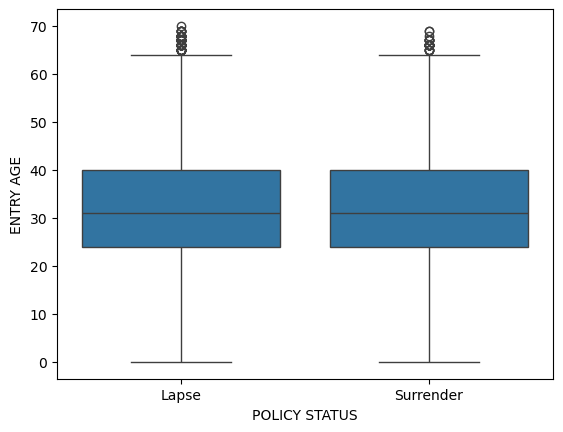

In [50]:
# Comparison of Entry Age across termination types
# Test 2: Check the distribution of entry age for Lapse and Surrender
sns.boxplot(data=df[df['POLICY STATUS'].isin(['Lapse', 'Surrender'])], 
            x='POLICY STATUS', y='ENTRY AGE')

# The age profile for both Lapse and Surrender also looks very similar, 
# with no significant differences in the median or interquartile ranges.

# Normally, individuals who surrender might be younger since they want to have more liquidity in hand
# But from this, we can see the entry age profile is very similar
# This shows that in each group, the same group of ages are likely to do both surrender and lapse
# They can be considered as one event

(0.0, 2000.0)

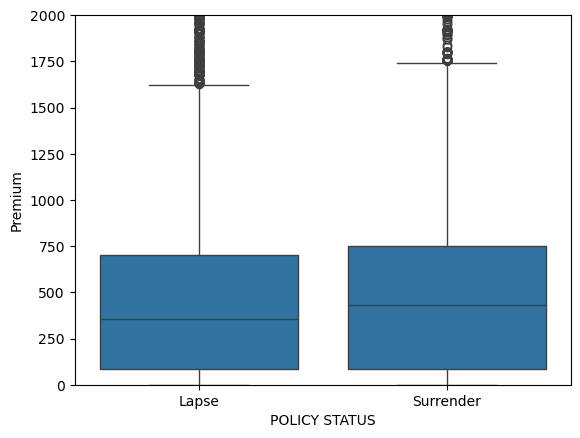

In [51]:
# Test 3: Check the distribution of premium for Lapse and Surrender
sns.boxplot(data=df[df['POLICY STATUS'].isin(['Lapse', 'Surrender'])], 
            x='POLICY STATUS', y='Premium')
plt.ylim(0, 2000)

# The premium profile for both Lapse and Surrender also looks very similar, 
# with no significant differences in the median or interquartile ranges.

# Normally, individuals who surrender might have higher premiums since they might want to cut down on expenses
# But from this, we can see the premium profile is very similar
# This shows that in each group, the same group of premiums are likely to do both surrender and lapse
# They can be considered as one event

In [52]:
# Test 4: Log rank test to compare the survival distributions of Lapse and Surrender
from lifelines.statistics import logrank_test

results = logrank_test(
    df[df['POLICY STATUS'] == 'Lapse']['Policy Year (Decimal)'],
    df[df['POLICY STATUS'] == 'Surrender']['Policy Year (Decimal)']
)

print(f"P-value: {results.p_value}")

# We have a very small survival distribution, we can categorize them into one event.

P-value: 3.462589201857256e-05


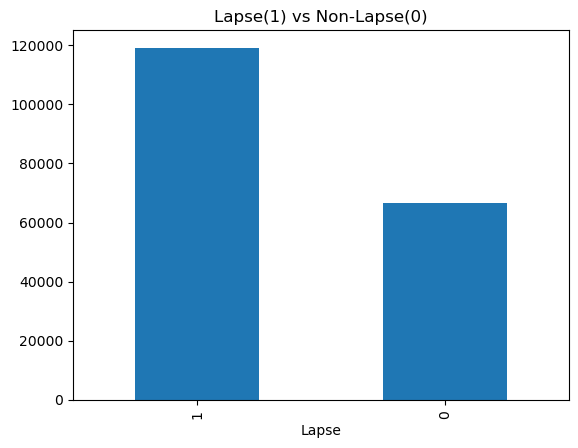

In [53]:
# Combine Lapse and Surrender into one category
# Grouping for analysis
mapping = {
    'Lapse': 1,
    'Surrender': 1,
    'Inforce': 0,
    'Death': 0,
    'Expired': 0
}

df['Lapse'] = df['POLICY STATUS'].map(mapping)
df['Lapse'].value_counts().plot(kind='bar')
plt.title('Lapse(1) vs Non-Lapse(0)')
plt.show()

# Check if Channel and Policy Type variables are important

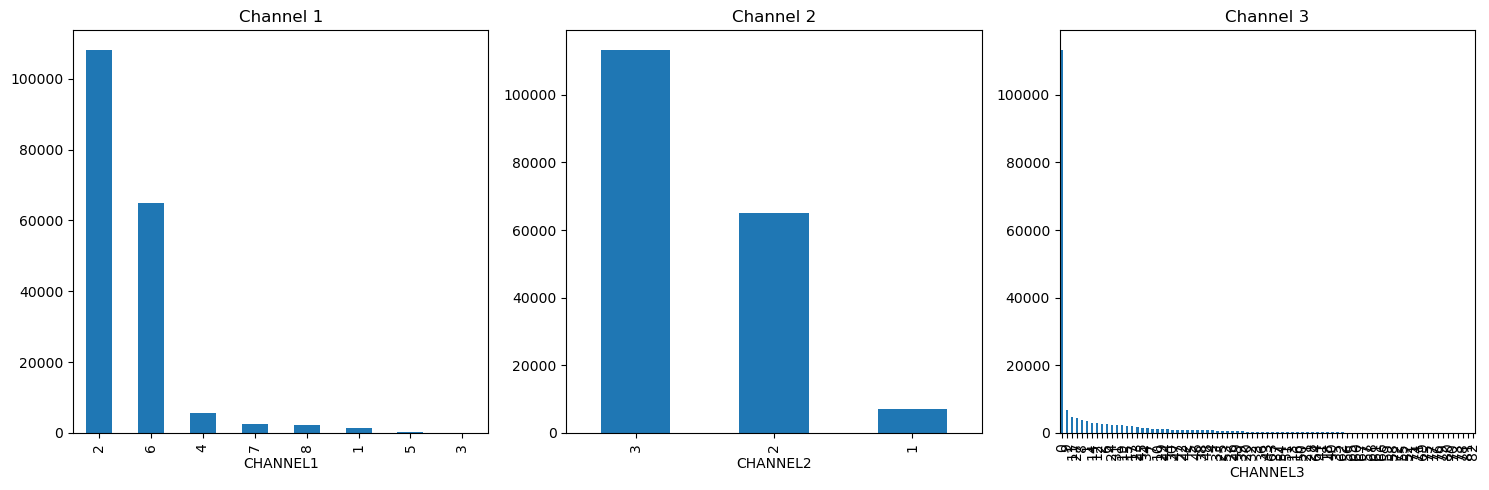

In [54]:
# Plot Channel 1,2,3 out to see their values

# 1. Create a single figure with 3 subplots (axes)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 2. Assign each plot to a specific axis using the 'ax' parameter
df['CHANNEL1'].value_counts().plot(kind='bar', ax=axes[0], title='Channel 1')
df['CHANNEL2'].value_counts().plot(kind='bar', ax=axes[1], title='Channel 2')
df['CHANNEL3'].value_counts().plot(kind='bar', ax=axes[2], title='Channel 3')

# 3. Clean up the layout so labels don't overlap
plt.tight_layout()
plt.show()

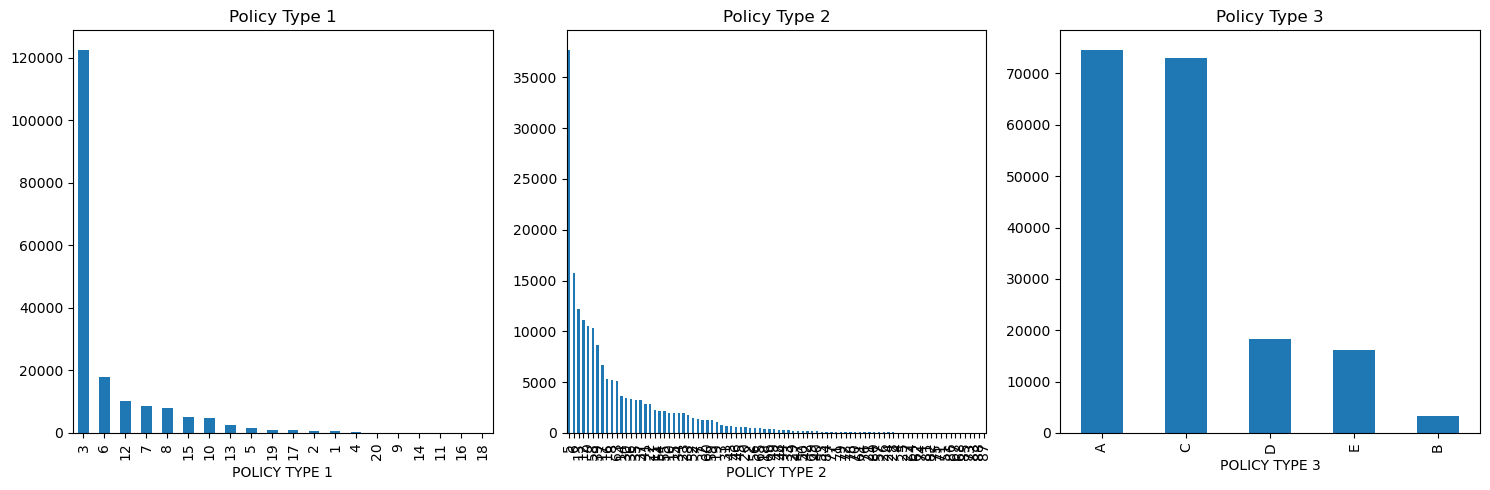

In [55]:
# Plot Channel 1,2,3 out to see their values

# 1. Create a single figure with 3 subplots (axes)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 2. Assign each plot to a specific axis using the 'ax' parameter
df['POLICY TYPE 1'].value_counts().plot(kind='bar', ax=axes[0], title='Policy Type 1')
df['POLICY TYPE 2'].value_counts().plot(kind='bar', ax=axes[1], title='Policy Type 2')
df['POLICY TYPE 3'].value_counts().plot(kind='bar', ax=axes[2], title='Policy Type 3')

# 3. Clean up the layout so labels don't overlap
plt.tight_layout()
plt.show()

In [56]:
df.columns

Index(['CHANNEL1', 'CHANNEL2', 'CHANNEL3', 'ENTRY AGE', 'SEX', 'POLICY TYPE 1',
       'POLICY TYPE 2', 'POLICY TYPE 3', 'PAYMENT MODE', 'POLICY STATUS',
       'BENEFIT', 'NON LAPSE GUARANTEED', 'SUBSTANDARD RISK',
       'NUMBER OF ADVANCE PREMIUM', 'INITIAL BENEFIT', 'Full Benefit?',
       'Policy Year (Decimal)', 'Policy Year', 'Premium', 'Issue Date',
       'Current Policy Date', 'Lapse'],
      dtype='object')

In [57]:
from lifelines.statistics import multivariate_logrank_test

# Test if 'CHANNEL1' categories have different lapse timings
results = multivariate_logrank_test(df['Policy Year (Decimal)'], 
                                    df['CHANNEL1'], 
                                    df['Lapse']) # where event is your Lapse indicator
print(f"Channel 1 Significance p-value: {results.p_value}")

Channel 1 Significance p-value: 0.0


In [58]:
from lifelines import CoxPHFitter

# Prepare data: keep only your predictors, the duration, and the event
# Note: You must one-hot encode categorical columns like CHANNEL1
df_dummy = pd.get_dummies(df[['Policy Year (Decimal)', 'Lapse', 'CHANNEL1', 'ENTRY AGE', 'Premium']], 
                          columns=['CHANNEL1'], drop_first=True)

cph = CoxPHFitter()
cph.fit(df_dummy, duration_col='Policy Year (Decimal)', event_col='Lapse')

# Display the statistical test results
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 185560 total observations, 66462 right-censored observations>
             duration col = 'Policy Year (Decimal)'
                event col = 'Lapse'
      baseline estimation = breslow
   number of observations = 185560
number of events observed = 119098
   partial log-likelihood = -1283922.09
         time fit was run = 2026-02-16 16:49:09 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
ENTRY AGE   0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Premium     0.00      1.00      0.00            0.00            0.00                1.00                1.00
CHANNEL1_2  2.00      7.38      0.03            1.93            2.07                6.91                7.89
CHANNEL1_3  0.65      1.92      0.12            0.42            0.89                1.52                2.44
CHANNEL1_4  1.47      4.35      0.04            1.40            1.54                4.04                4.69
CHANNEL1_5  2.14      8.53      0.07            2.00            2.29                7.36                9.87
CHANNEL1_6  3.25     25.80      0.03            3.18            3.32               24.10               27.61
CHANNEL1_7  2.83     16.89      0.11            2.61            3.05               13.55               21.05
CHANNEL1_8  4.73    113.76      0.05            4.63            4.84              102.84              125.84

            cmp to     z      p  -log2(p)
covariate                                
ENTRY AGE     0.00  0.73   0.47      1.10
Premium       0.00 16.82 <0.005    208.50
CHANNEL1_2    0.00 58.77 <0.005       inf
CHANNEL1_3    0.00  5.40 <0.005     23.83
CHANNEL1_4    0.00 38.45 <0.005       inf
CHANNEL1_5    0.00 28.68 <0.005    598.65
CHANNEL1_6    0.00 93.61 <0.005       inf
CHANNEL1_7    0.00 25.14 <0.005    460.76
CHANNEL1_8    0.00 91.95 <0.005       inf
---
Concordance = 0.64
Partial AIC = 2567862.18
log-likelihood ratio test = 37175.64 on 9 df
-log2(p) of ll-ratio test = inf

In [59]:
from lifelines import CoxPHFitter

# Prepare data: keep only your predictors, the duration, and the event
# Note: You must one-hot encode categorical columns like CHANNEL1
df_dummy = pd.get_dummies(df[['Policy Year (Decimal)', 'Lapse', 'CHANNEL2', 'ENTRY AGE', 'Premium']], 
                          columns=['CHANNEL2'], drop_first=True)

cph = CoxPHFitter()
cph.fit(df_dummy, duration_col='Policy Year (Decimal)', event_col='Lapse')

# Display the statistical test results
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 185560 total observations, 66462 right-censored observations>
             duration col = 'Policy Year (Decimal)'
                event col = 'Lapse'
      baseline estimation = breslow
   number of observations = 185560
number of events observed = 119098
   partial log-likelihood = -1286187.68
         time fit was run = 2026-02-16 16:49:11 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
ENTRY AGE   0.00      1.00      0.00           -0.00            0.00                1.00                1.00
Premium     0.00      1.00      0.00            0.00            0.00                1.00                1.00
CHANNEL2_2  2.27      9.65      0.02            2.23            2.30                9.31               10.00
CHANNEL2_3  1.05      2.85      0.02            1.01            1.08                2.76                2.95

            cmp to      z      p  -log2(p)
covariate                                 
ENTRY AGE     0.00   0.45   0.65      0.62
Premium       0.00  22.56 <0.005    372.02
CHANNEL2_2    0.00 124.06 <0.005       inf
CHANNEL2_3    0.00  61.29 <0.005       inf
---
Concordance = 0.63
Partial AIC = 2572383.35
log-likelihood ratio test = 32644.46 on 4 df
-log2(p) of ll-ratio test = inf

In [60]:
from lifelines import CoxPHFitter

# Prepare data: keep only your predictors, the duration, and the event
# Note: You must one-hot encode categorical columns like CHANNEL1
df_dummy = pd.get_dummies(df[['Policy Year (Decimal)', 'Lapse', 'CHANNEL3', 'ENTRY AGE', 'Premium']], 
                          columns=['CHANNEL3'], drop_first=True)

cph = CoxPHFitter()
cph.fit(df_dummy, duration_col='Policy Year (Decimal)', event_col='Lapse')

# Display the statistical test results
cph.print_summary()

/opt/anaconda3/lib/python3.13/site-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['CHANNEL3_52', 'CHANNEL3_55', 'CHANNEL3_69', 'CHANNEL3_70', 'CHANNEL3_71', 'CHANNEL3_72', 'CHANNEL3_73', 'CHANNEL3_74', 'CHANNEL3_75', 'CHANNEL3_76', 'CHANNEL3_77', 'CHANNEL3_78', 'CHANNEL3_79', 'CHANNEL3_80', 'CHANNEL3_81', 'CHANNEL3_82'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/opt/anaconda3/lib/python3.13/site-packages/lifelines/utils/__init__.py:1120: ConvergenceWarning: Column CHANNEL3_69 have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['Lapse'].astype(bool)
>>> print(df.loc[events, 'CHANNEL3_69'].var())
>>> print(df.loc

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

In [ ]:
from lifelines import CoxPHFitter

# Prepare data: keep only your predictors, the duration, and the event
# Note: You must one-hot encode categorical columns like CHANNEL1
df_dummy = pd.get_dummies(df[['Policy Year (Decimal)', 'Lapse', 'POLICY TYPE 3', 'ENTRY AGE', 'Premium']], 
                          columns=['POLICY TYPE 3'], drop_first=True)

cph = CoxPHFitter()
cph.fit(df_dummy, duration_col='Policy Year (Decimal)', event_col='Lapse')

# Display the statistical test results
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 185560 total observations, 66462 right-censored observations>
             duration col = 'Policy Year (Decimal)'
                event col = 'Lapse'
      baseline estimation = breslow
   number of observations = 185560
number of events observed = 119098
   partial log-likelihood = -1300208.44
         time fit was run = 2026-02-16 15:47:21 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
ENTRY AGE        0.00      1.00      0.00            0.00            0.00                1.00                1.00
Premium         -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
POLICY TYPE 3_B -1.04      0.35      0.04           -1.12           -0.96                0.33                0.38
POLICY TYPE 3_C -0.14      0.87      0.01           -0.15           -0.12                0.86                0.88
POLICY TYPE 3_D -0.44      0.65      0.01           -0.46           -0.42                0.63                0.66
POLICY TYPE 3_E  0.32      1.38      0.01            0.30            0.34                1.35                1.40

                 cmp to      z      p  -log2(p)
covariate                                      
ENTRY AGE          0.00   2.20   0.03      5.18
Premium            0.00  -4.43 <0.005     16.68
POLICY TYPE 3_B    0.00 -25.21 <0.005    463.57
POLICY TYPE 3_C    0.00 -20.27 <0.005    301.07
POLICY TYPE 3_D    0.00 -40.81 <0.005       inf
POLICY TYPE 3_E    0.00  30.95 <0.005    696.10
---
Concordance = 0.55
Partial AIC = 2600428.89
log-likelihood ratio test = 4602.93 on 6 df
-log2(p) of ll-ratio test = inf

$p$ (p-value): Look for values $< 0.05$: If a specific Channel has a $p < 0.05$, it is a statistically significant predictor of lapse.exp(coef) 

(Hazard Ratio):If $> 1$: This category increases the risk of lapse (e.g., a ratio of $1.5$ means 50% more likely to lapse). If $< 1$: This category decreases the risk (more loyal).

Concordance Index: This is the "accuracy" of your model (0.5 is random guessing, 1.0 is perfect)

/var/folders/x3/l0m6t38s60sd4cjgtqj1gdp80000gn/T/ipykernel_80929/378959816.py:12: Pandas4Warning: The copy keyword is deprecated and will be removed in a future version. Copy-on-Write is active in pandas since 3.0 which utilizes a lazy copy mechanism that defers copies until necessary. Use .copy() to make an eager copy if necessary.
  feat_importances.nlargest(10).plot(kind='barh')


Text(0.5, 1.0, 'Top 10 Predictors of Lapse')

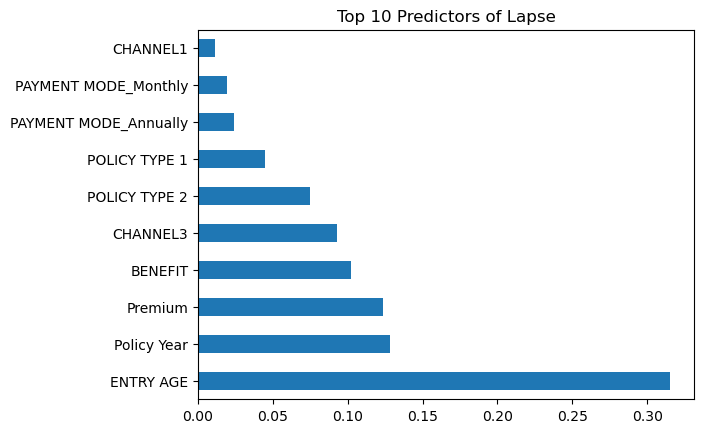

In [ ]:
from sklearn.ensemble import RandomForestClassifier
cols_to_drop = ['POLICY STATUS', 'Policy Year (Decimal)', 'Issue Date', 'Current Policy Date', 'Lapse']

# Define X (features) and y (binary lapse indicator)
X = pd.get_dummies(df.drop(columns=cols_to_drop))
y = df['Lapse']

rf = RandomForestClassifier().fit(X, y)

# Plot top features
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Predictors of Lapse')

## Dilemma: 
Should we include Channel 1, Policy Type 1, 2 and Channel 3?
They are not really interpretable (we can make up one for that)?

In [ ]:
df.columns

Index(['CHANNEL1', 'CHANNEL2', 'CHANNEL3', 'ENTRY AGE', 'SEX', 'POLICY TYPE 1',
       'POLICY TYPE 2', 'POLICY TYPE 3', 'PAYMENT MODE', 'POLICY STATUS',
       'BENEFIT', 'NON LAPSE GUARANTEED', 'SUBSTANDARD RISK',
       'NUMBER OF ADVANCE PREMIUM', 'INITIAL BENEFIT', 'Full Benefit?',
       'Policy Year (Decimal)', 'Policy Year', 'Premium', 'Issue Date',
       'Current Policy Date', 'Lapse'],
      dtype='str')

In [ ]:
# I want to see the predictive power loss if I remove all channel and policy type

import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# --- STEP 1: PRE-PROCESSING ---
# We must remove dates and non-numeric columns that get_dummies might miss
# Also, ensure 'Lapse' is excluded from X but kept for y
target_col = 'Lapse' 
cols_to_ignore = ['Policy Year (Decimal)', 'Issue Date', 'Current Policy Date', 'POLICY STATUS']

# Convert Y/N or other strings to dummies automatically
X_full = pd.get_dummies(df.drop(columns=cols_to_ignore + [target_col]), drop_first=True)
y = df[target_col].astype(int)

# --- STEP 2: DEFINE FEATURE SETS ---
# Match the exact names from your screenshot
cols_to_remove = ['CHANNEL1', 'CHANNEL2', 'CHANNEL3', 'POLICY TYPE 1', 'POLICY TYPE 2', 'POLICY TYPE 3']

# Check if columns exist before dropping to avoid KeyError
existing_cols_to_remove = [c for c in cols_to_remove if c in X_full.columns]
X_reduced = X_full.drop(columns=existing_cols_to_remove)

# --- STEP 3: SPLIT ---
X_train_f, X_test_f, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42)
X_train_r, X_test_r, _, _ = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# --- STEP 4: TRAIN FULL MODEL ---
rf_full = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_full.fit(X_train_f, y_train)
probs_full = rf_full.predict_proba(X_test_f)[:, 1]
mse_full = mean_squared_error(y_test, probs_full)

# --- STEP 5: TRAIN REDUCED MODEL ---
rf_reduced = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf_reduced.fit(X_train_r, y_train)
probs_reduced = rf_reduced.predict_proba(X_test_r)[:, 1]
mse_reduced = mean_squared_error(y_test, probs_reduced)

# --- STEP 6: RESULTS ---
print(f"Full Model MSE:    {mse_full:.5f}")
print(f"Reduced Model MSE: {mse_reduced:.5f}")
loss = ((mse_reduced - mse_full) / mse_full) * 100
print(f"Performance Loss:  {loss:.2f}%")

Full Model MSE:    0.19665
Reduced Model MSE: 0.19804
Performance Loss:  0.71%


## Result check:
It seems that we do not loss a lot of predictive power if we remove CHANNEL and POLICY TYPE variables.
Since they are not interpretable, and the potential improvement in MSE is not worth the effort taken to contextualize them, and we want to ensure an interpretable results, we can remove those variables. 

In [ ]:
# Drop Channel and Policy Type columns
df.drop(columns=['CHANNEL1', 'CHANNEL2', 'CHANNEL3', 'POLICY TYPE 1', 'POLICY TYPE 2', 'POLICY TYPE 3', 'POLICY STATUS'], inplace=True)

In [ ]:
df.head()

,ENTRY AGE,SEX,PAYMENT MODE,BENEFIT,NON LAPSE GUARANTEED,SUBSTANDARD RISK,NUMBER OF ADVANCE PREMIUM,INITIAL BENEFIT,Full Benefit?,Policy Year (Decimal),Policy Year,Premium,Issue Date
0,36,F,Annually,200000.0,NO NLG,0.0,0,0.0,N,8.000000,9,280.0,11-Aug
1,42,M,Annually,100000.0,NO NLG,0.0,0,0.0,N,8.000000,9,200.0,11-Aug
2,40,M,Annually,80000.0,NO NLG,0.0,0,0.0,N,8.000000,9,1289.0,11-Aug
3,39,M,Monthly,100000.0,NO NLG,0.0,0,0.0,N,8.000000,9,216.0,11-Aug
4,44,M,Annually,100000.0,NO NLG,0.0,0,0.0,N,7.916667,8,140.0,11-Sep


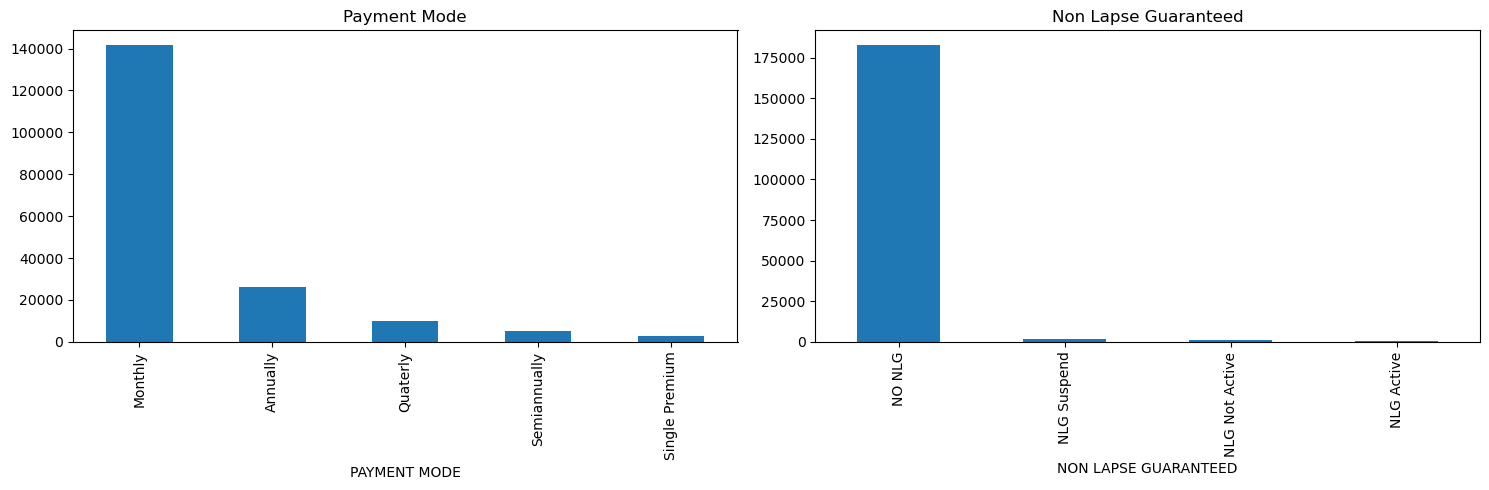

In [ ]:
# I am still unsure about Substandard Risk, Full Benefit?, Initial Benefit, Number of Advance Premium meaning
# I want to plot them out to see if their frequency distributino

# 1. Create a single figure with 2 subplots (axes)
fig, axes = plt.subplots(1,2, figsize=(15, 5))

# 2. Assign each plot to a specific axis using the 'ax' parameter
df['PAYMENT MODE'].value_counts().plot(kind='bar', ax=axes[0], title='Payment Mode')
df['NON LAPSE GUARANTEED'].value_counts().plot(kind='bar', ax=axes[1], title='Non Lapse Guaranteed')
#df['SUBSTANDARD RISK'].value_counts().plot(kind='bar', ax=axes[0,2], title='Policy Type 3')
#df['NUMBER OF ADVANCE PREMIUM'].value_counts().plot(kind='bar', ax=axes[1,0], title='Policy Type 3')
#df['INITIAL BENEFIT'].value_counts().plot(kind='bar', ax=axes[1,1], title='Policy Type 3')
#df['Full Benefit?'].value_counts().plot(kind='bar', ax=axes[1,2], title='Policy Type 3')


# 3. Clean up the layout so labels don't overlap
plt.tight_layout()
plt.show()

# Substandard Risk (Negative value)

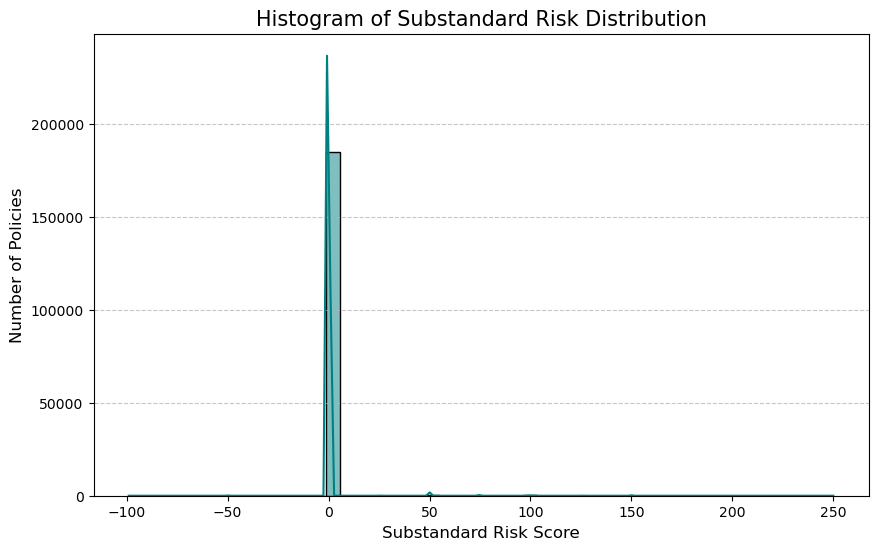

In [ ]:
# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['SUBSTANDARD RISK'], bins=50, kde=True, color='teal')

# Add titles and labels
plt.title('Histogram of Substandard Risk Distribution', fontsize=15)
plt.xlabel('Substandard Risk Score', fontsize=12)
plt.ylabel('Number of Policies', fontsize=12)

# Optional: Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
df[df['SUBSTANDARD RISK']<0]

,ENTRY AGE,SEX,PAYMENT MODE,BENEFIT,NON LAPSE GUARANTEED,SUBSTANDARD RISK,NUMBER OF ADVANCE PREMIUM,INITIAL BENEFIT,Full Benefit?,Policy Year (Decimal),Policy Year,Premium,Issue Date
111895,12,F,Annually,200.0,NO NLG,-99.00,0,0.0,N,4.916667,5,-111.0,14-Sep
112474,7,M,Annually,200.0,NO NLG,-98.99,0,0.0,N,4.916667,5,-103.0,14-Sep
120871,39,M,Monthly,34000.0,NO NLG,-50.00,0,0.0,N,2.416667,3,349.0,17-Mar
127454,24,M,Monthly,20800.0,NO NLG,-50.00,0,0.0,N,2.333333,3,106.0,17-Apr
127568,28,F,Monthly,30000.0,NO NLG,-50.00,0,0.0,N,2.333333,3,169.0,17-Apr
130766,47,M,Monthly,20000.0,NO NLG,-50.00,0,0.0,N,2.416667,3,481.0,17-Mar
137340,40,F,Monthly,26000.0,NO NLG,-50.00,0,0.0,N,2.416667,3,389.0,17-Mar
140547,23,F,Monthly,60000.0,NO NLG,-50.00,0,0.0,N,2.333333,3,304.0,17-Apr
140563,33,F,Monthly,26000.0,NO NLG,-50.00,0,0.0,N,2.416667,3,180.0,17-Mar
143777,30,M,Monthly,65000.0,NO NLG,-49.99,0,0.0,N,2.416667,3,417.0,17-Mar


In [ ]:
# Check how many policies/proportion has negative standard risk score
df_negative = df[df['SUBSTANDARD RISK']<0]
df_negative.shape[0]/ df.shape[0]*100

# 1.25% of the policies have negative standard risk score, which is a small proportion. 
# Depending on the context and the importance of this variable, we might consider either removing these records or treating them as a separate category in our analysis.

0.012394912696701876

## Dilemma:
Should we remove all these rows with negative risk scoring
In insurance, Substandard Risk refers to a policyholder who does not meet the requirements for standard insurance rates due to a higher-than-average risk profile.
The risk should always starts from 0.

We can either
1) Remove these rows with negative substandard risk, since it only occupies a small portion of the total number of rows
2) Rename these numbers (not sure whether this is appropriate)

In [ ]:
df.shape

(185560, 13)

In [ ]:
df.columns

Index(['ENTRY AGE', 'SEX', 'PAYMENT MODE', 'BENEFIT', 'NON LAPSE GUARANTEED',
       'SUBSTANDARD RISK', 'NUMBER OF ADVANCE PREMIUM', 'INITIAL BENEFIT',
       'Full Benefit?', 'Policy Year (Decimal)', 'Policy Year', 'Premium',
       'Issue Date'],
      dtype='object')

# NLG Definition

**Non-Lapse Guaranteed (NLG) is a policy feature that ensures the death benefit remains in force even if the policy's cash value drops to zero, provided a specific premium requirement is met.**

1. NLG Suspend
- Meaning: The guarantee has been temporarily paused or "suspended." This typically happens when a policyholder misses a required premium payment or takes a policy loan that violates the guarantee's specific terms.
- Relationship to Lapse: This category shows a lapse rate of 1.0 (100%) in your chart. This indicates that once the safety net of the NLG is suspended, the policy is extremely vulnerable and, in your current data sample, almost always results in a lapse.


2. NLG Active
- Meaning: The guarantee is fully functional. The policyholder is meeting all premium requirements, and the insurance company is contractually obligated to keep the policy active regardless of cash value performance.
- Relationship to Lapse: Interestingly, this group has a high lapse rate (approx. 0.82). This suggests that even with a guarantee in place, a large portion of these policyholders are either choosing to walk away or failing to meet the basic premium payments required to keep the "Active" status.


3. NO NLG
- Meaning: These are standard policies that do not have the Non-Lapse Guarantee feature. The policy stays active only as long as there is enough cash value to cover the monthly insurance costs.
- Relationship to Lapse: This group has a moderate lapse rate (approx. 0.63). They are actually lapsing less frequently than those with an "Active" NLG, which might imply these policies have more stable cash values or more traditional payment structures.


4. NLG Not Active
- Meaning: This likely refers to policies that could have had the guarantee, but it was never triggered or the policy did not qualify for it at the time of the data snapshot.
- Relationship to Lapse: This category has the lowest lapse rate (approx. 0.37). These policyholders appear to be the most stable group in your dataset, potentially because they are maintaining their policies through traditional cash value accumulation rather than relying on the guarantee feature.

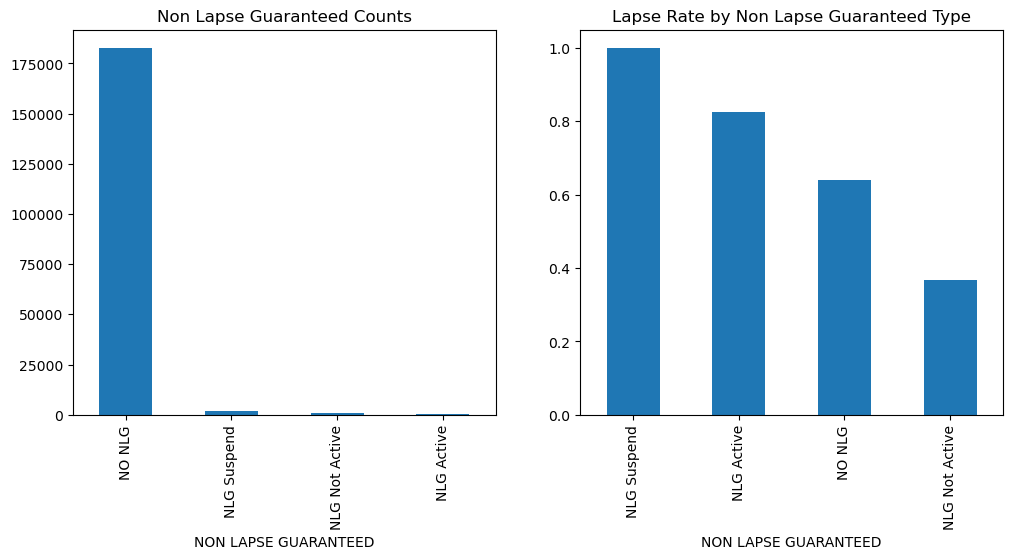

In [61]:
# Non Lapse Guaranteed counts
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
df['NON LAPSE GUARANTEED'].value_counts().plot(kind='bar')
plt.title('Non Lapse Guaranteed Counts')

plt.subplot(1,2,2)
lapse_by_type = df.groupby('NON LAPSE GUARANTEED')['Lapse'].mean().sort_values(ascending=False)
lapse_by_type.plot(kind='bar')
plt.title('Lapse Rate by Non Lapse Guaranteed Type')
plt.show()

# NLG = feature that keep policy in force even if the cash value drops to 0, 
# provided a minimum premium is paid

# Most of the NLG is NO NLG, which means that when the cash value drops to 0, the policy will lapse
# They do not have protection, and are very sensitive to market conditions/ interest rate changes
# This shows it is important to study how interest rates affects their lapse rates

# Lapse rate exist is every NLG category

In [62]:
df.columns

Index(['CHANNEL1', 'CHANNEL2', 'CHANNEL3', 'ENTRY AGE', 'SEX', 'POLICY TYPE 1',
       'POLICY TYPE 2', 'POLICY TYPE 3', 'PAYMENT MODE', 'POLICY STATUS',
       'BENEFIT', 'NON LAPSE GUARANTEED', 'SUBSTANDARD RISK',
       'NUMBER OF ADVANCE PREMIUM', 'INITIAL BENEFIT', 'Full Benefit?',
       'Policy Year (Decimal)', 'Policy Year', 'Premium', 'Issue Date',
       'Current Policy Date', 'Lapse'],
      dtype='object')

In [63]:
df.head()

,CHANNEL1,CHANNEL2,CHANNEL3,ENTRY AGE,SEX,POLICY TYPE 1,POLICY TYPE 2,POLICY TYPE 3,PAYMENT MODE,POLICY STATUS,...,SUBSTANDARD RISK,NUMBER OF ADVANCE PREMIUM,INITIAL BENEFIT,Full Benefit?,Policy Year (Decimal),Policy Year,Premium,Issue Date,Current Policy Date,Lapse
0,1,1,1,36,F,1,1,A,Annually,Inforce,...,0.0,0,0.0,N,8.000000,9,280.0,2011-08-01,2019-08-01,0
1,1,1,1,42,M,1,2,A,Annually,Inforce,...,0.0,0,0.0,N,8.000000,9,200.0,2011-08-01,2019-08-01,0
2,1,1,2,40,M,2,3,A,Annually,Lapse,...,0.0,0,0.0,N,8.000000,9,1289.0,2011-08-01,2019-08-01,1
3,1,1,3,39,M,1,2,A,Monthly,Lapse,...,0.0,0,0.0,N,8.000000,9,216.0,2011-08-01,2019-08-01,1
4,1,1,4,44,M,1,2,A,Annually,Lapse,...,0.0,0,0.0,N,7.916667,8,140.0,2011-09-01,2019-08-01,1


In [64]:
df.to_csv('insurance_data_lapsebin.csv', index=False)